
=== Gutenberg ===
Sentences: 94428


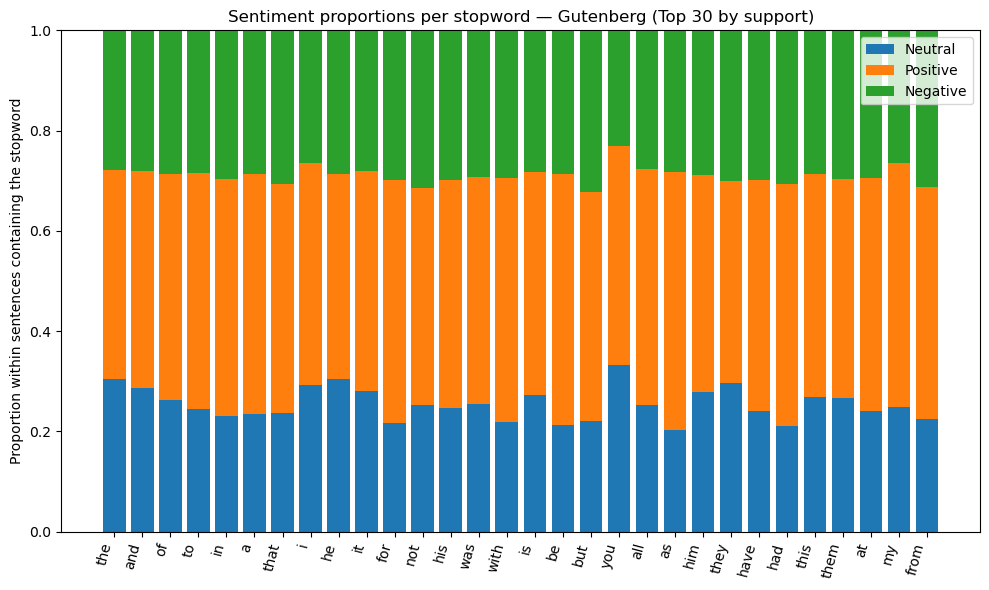

Saved (relative):
- artifacts/spec9_gutenberg_stopword_sentiment.csv
- artifacts/spec9_gutenberg_stacked.png

=== WebText ===
Sentences: 27641


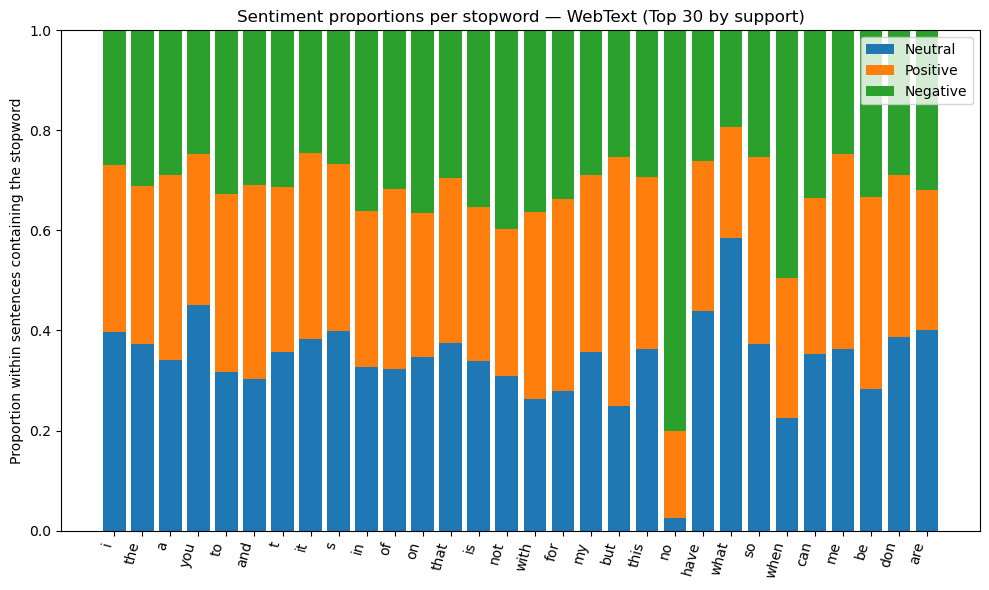

Saved (relative):
- artifacts/spec9_webtext_stopword_sentiment.csv
- artifacts/spec9_webtext_stacked.png

=== NPS_Chat ===
Sentences: 15


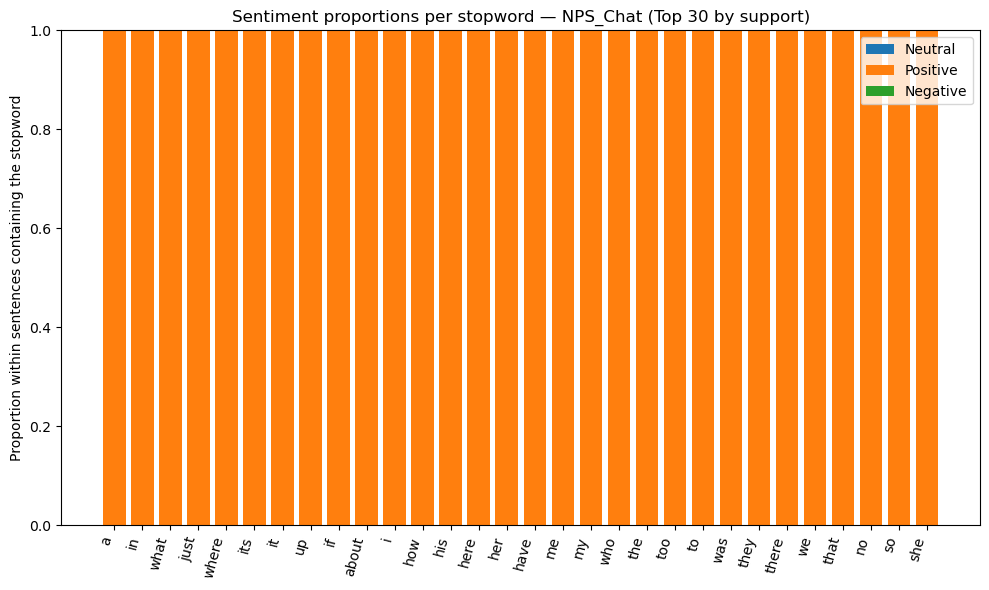

Saved (relative):
- artifacts/spec9_nps_chat_stopword_sentiment.csv
- artifacts/spec9_nps_chat_stacked.png

Combined CSV: artifacts/spec9_all_corpora_stopword_sentiment.csv

Summary saved: artifacts/spec9_summary_by_corpus.csv


,corpus,total_support,pos,neu,neg
0,Gutenberg,769893,0.454222,0.254694,0.291085
1,WebText,113321,0.331739,0.354039,0.314222
2,NPS_Chat,1392,1.000000,0.000000,0.000000


In [1]:
# Spec 9 — VADER sentiment over sentences (Gutenberg, WebText, NPS Chat)
# For each corpus:
#   - Sentencize text
#   - VADER polarity per sentence
#   - For each stopword: proportion of sentences (containing that word) that are pos/neu/neg
# Saves: per-corpus CSVs + combined CSV + stacked bar charts (Top-30 by support)

import os, nltk, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict, Counter

# --- paths ---
ART_DIR = os.path.abspath("../artifacts" if os.path.basename(os.getcwd())=="notebooks" else "./artifacts")
os.makedirs(ART_DIR, exist_ok=True)

# --- downloads ---
for pkg in ["punkt","stopwords","gutenberg","webtext","nps_chat","vader_lexicon"]:
    nltk.download(pkg, quiet=True)

from nltk.corpus import stopwords, gutenberg, webtext, nps_chat
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()
L = set(stopwords.words("english"))

# --- helpers ---
def sentences_from_corpus(name):
    """Return list of sentences (strings) for a corpus."""
    if name == "gutenberg":
        words = []
        for fid in gutenberg.fileids():
            words.extend(gutenberg.raw(fid))
        text = "".join(words)
        sents = sent_tokenize(text)
    elif name == "webtext":
        text = " ".join(" ".join(webtext.words(fid)) for fid in webtext.fileids())
        sents = sent_tokenize(text)
    elif name == "nps_chat":
        # chat posts are short; treat each post as a sentence already
        sents = [" ".join(nps_chat.words(fid)) for fid in nps_chat.fileids()]
    else:
        sents = []
    # light cleanup; keep non-empty
    sents = [s.strip() for s in sents if s and isinstance(s, str)]
    return sents

def sent_label(text):
    """Map VADER compound to pos/neu/neg labels."""
    c = SIA.polarity_scores(text)["compound"]
    if c >= 0.05:  return "pos"
    if c <= -0.05: return "neg"
    return "neu"

def tokens_alpha_lower(text):
    """Lowercase alphabetic tokens."""
    return [w.lower() for w in word_tokenize(text) if w.isalpha()]

def stopword_sentiment_proportions(sents):
    """
    For each stopword w: count sentences containing w by sentiment label.
    Return DataFrame with proportions and support (num sentences containing w).
    """
    counts = {w: Counter({"pos":0,"neu":0,"neg":0}) for w in L}
    support = Counter()

    for s in sents:
        lbl = sent_label(s)
        toks = set(tokens_alpha_lower(s))   # presence (once per sentence)
        sw_in = toks & L
        for w in sw_in:
            counts[w][lbl] += 1
            support[w] += 1

    rows = []
    for w in sorted(L):
        sup = support[w]
        if sup == 0:
            continue
        pos = counts[w]["pos"]/sup
        neu = counts[w]["neu"]/sup
        neg = counts[w]["neg"]/sup
        rows.append({"stopword": w, "support": sup, "pos": pos, "neu": neu, "neg": neg})
    return pd.DataFrame(rows).sort_values("support", ascending=False).reset_index(drop=True)

def plot_stacked(df, corpus_name, outpath, top=30):
    """Stacked bar for top stopwords by support."""
    if df.empty: 
        return
    d = df.head(top)
    plt.figure(figsize=(10,6))
    plt.bar(d["stopword"], d["neu"], label="Neutral")
    plt.bar(d["stopword"], d["pos"], bottom=d["neu"], label="Positive")
    plt.bar(d["stopword"], d["neg"], bottom=d["neu"]+d["pos"], label="Negative")
    plt.xticks(rotation=75, ha="right")
    plt.ylim(0,1)
    plt.title(f"Sentiment proportions per stopword — {corpus_name} (Top {top} by support)")
    plt.ylabel("Proportion within sentences containing the stopword")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=140)
    plt.show()

# --- main ---
CORPORA = [("gutenberg","Gutenberg"), ("webtext","WebText"), ("nps_chat","NPS_Chat")]
all_rows = []

for code, pretty in CORPORA:
    print(f"\n=== {pretty} ===")
    sents = sentences_from_corpus(code)
    print(f"Sentences: {len(sents)}")

    df = stopword_sentiment_proportions(sents)
    csv_path = os.path.join(ART_DIR, f"spec9_{code}_stopword_sentiment.csv")
    df.to_csv(csv_path, index=False)

    # stacked bar
    png_path = os.path.join(ART_DIR, f"spec9_{code}_stacked.png")
    plot_stacked(df, pretty, png_path, top=30)

    # add corpus tag for combined export
    if not df.empty:
        dft = df.copy()
        dft["corpus"] = pretty
        all_rows.append(dft)

    print("Saved (relative):")
    print(f"- artifacts/{os.path.basename(csv_path)}")
    print(f"- artifacts/{os.path.basename(png_path)}")

# combined file
if all_rows:
    df_all = pd.concat(all_rows, ignore_index=True)
    out_all = os.path.join(ART_DIR, "spec9_all_corpora_stopword_sentiment.csv")
    df_all.to_csv(out_all, index=False)
    print(f"\nCombined CSV: artifacts/{os.path.basename(out_all)}")

# quick overall summary per corpus (average proportions weighted by support)
def weighted_avg_summary(df):
    w = df["support"].values
    tot = w.sum()
    if tot == 0: 
        return {"pos":0.0,"neu":0.0,"neg":0.0}
    return {
        "pos": float((df["pos"]*w).sum()/tot),
        "neu": float((df["neu"]*w).sum()/tot),
        "neg": float((df["neg"]*w).sum()/tot),
        "total_support": int(tot)
    }

summ_rows = []
for code, pretty in CORPORA:
    fp = os.path.join(ART_DIR, f"spec9_{code}_stopword_sentiment.csv")
    if os.path.exists(fp):
        d = pd.read_csv(fp)
        s = weighted_avg_summary(d)
        s["corpus"] = pretty
        summ_rows.append(s)
if summ_rows:
    df_sum = pd.DataFrame(summ_rows)[["corpus","total_support","pos","neu","neg"]]
    df_sum.to_csv(os.path.join(ART_DIR, "spec9_summary_by_corpus.csv"), index=False)
    print("\nSummary saved: artifacts/spec9_summary_by_corpus.csv")
    display(df_sum)
